## Generative document comprehension

Ollama corresction

[2025/04/13 09:39:26] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.4, det_db_box_thresh=0.5, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

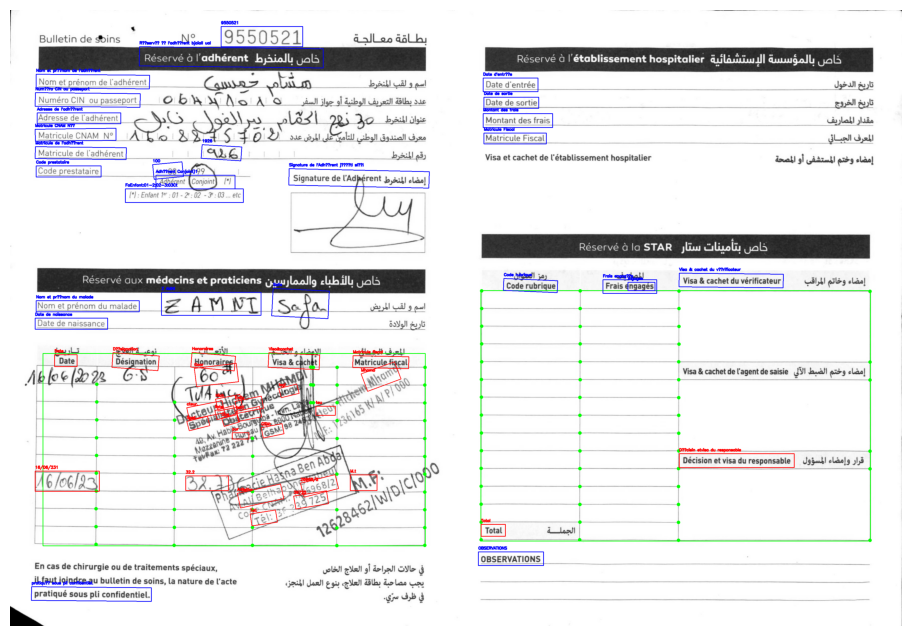

In [2]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
from paddleocr import PaddleOCR
import json
import requests

# -------- CONFIGURATION ----------
OCR_ENGINE = PaddleOCR(
    use_angle_cls=True,
    lang="fr",
    use_gpu=False,
    det_db_thresh=0.4,
    det_db_box_thresh=0.5,
    det_db_unclip_ratio=2.0,
    rec_algorithm="SVTR_LCNet",
    max_text_length=100,
)

OLLAMA_API_URL = "http://localhost:11434/api/generate"

# -------- TABLE DETECTION FUNCTIONS --------
def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    """Thresholds an image using OpenCV's adaptiveThreshold."""
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
        )
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blocksize,
            c,
        )
    return img, threshold

def find_lines(threshold, regions=None, direction="horizontal", line_scale=15, iterations=0):
    """Finds horizontal and vertical lines by applying morphological transformations."""
    lines = []
    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    else:
        raise ValueError("Specify direction as either 'vertical' or 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y:y + h, x:x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))
    return dmask, lines

def find_contours(vertical, horizontal):
    """Finds table boundaries using OpenCV's findContours."""
    mask = vertical + horizontal
    try:
        _, contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont, mask

def find_joints(contours, vertical, horizontal):
    """Finds joints/intersections inside each table boundary."""
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y:y + h, x:x + w]
        try:
            _, jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        except ValueError:
            jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        if len(jc) <= 4:
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y + h, x + w, y)] = joint_coords
    return tables

# -------- FIELD EXTRACTION FUNCTIONS --------
def contains_arabic(text):
    return bool(re.search("[\\u0600-\\u06FF]", text))

def is_likely_handwritten(text, box, image):
    width = box[2][0] - box[0][0]
    height = box[2][1] - box[0][1]
    aspect_ratio = width / height if height > 0 else 0
    if aspect_ratio < 0.5 or aspect_ratio > 10 or len(text) < 3:
        return True
    return False

def is_likely_field_name(text):
    text = text.strip().upper()
    word_count = len(text.split())
    if word_count > 6:
        return False

    field_keywords = [
        "NOM", "PRENOM", "ADRESSE", "MATRICULE", "DATE", "MONTANT", "CODE",
        "VISA", "HONORAIRES", "DESIGNATION", "TOTAL", "OBSERVATIONS", "FRAIS",
        "NUMERO", "SIGNATURE", "RESERVE", "SORTIE", "ENTREE", "MATRICULE FISCAL"
    ]
    if any(keyword in text for keyword in field_keywords):
        return True

    non_field_patterns = [
        r"BULLETIN DE SOINS",
        r"RESERVE A L'ETABLISSEMENT HOSPITALIER",
        r"RESERVE A STAR",
        r"RESERVE AUX MEDECINS ET PRATICIENS",
        r"POUR LES CHIRURGIES OU DE TRAITEMENTS SPECIAUX",
        r"IL FAUT JOINDRE AU BULLETIN DE SOINS"
    ]
    if any(re.search(pattern, text, re.IGNORECASE) for pattern in non_field_patterns):
        return False

    if len(text) > 50:
        return False

    return True

def preprocess_image(image, mode):
    """Prétraite l'image selon le mode spécifié."""
    image_np = np.array(image)
    if mode == "grayscale":
        return cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    elif mode == "rgb":
        return image_np
    elif mode == "binary":
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -2
        )
    elif mode == "contrast":
        img_lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img_lab = cv2.merge((l, a, b))
        return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError(f"Mode {mode} non supporté.")

def boxes_overlap(box1, box2, threshold=0.5):
    """Vérifie si deux boîtes se chevauchent avec un seuil d'intersection (IoU)."""
    x1, y1 = box1[0][0], box1[0][1]
    x2, y2 = box1[2][0], box1[2][1]
    x1_p, y1_p = box2[0][0], box2[0][1]
    x2_p, y2_p = box2[2][0], box2[2][1]

    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou > threshold

def extract_text_and_layout(image):
    """Extract text and layout avec OCR séquentiel sur plusieurs modes."""
    modes = ["grayscale", "rgb", "binary", "contrast"]  # Ordre défini, commence par grayscale
    extracted_data = []

    for mode in modes:
        print(f"[INFO] Applying OCR with {mode} mode")
        preprocessed_img = preprocess_image(image, mode)
        results = OCR_ENGINE.ocr(preprocessed_img, cls=True)

        if results is None:
            continue
        for line in results:
            if line is None:
                continue
            for word_info in line:
                if word_info is None:
                    continue
                text = word_info[1][0]
                confidence = word_info[1][1]
                box = word_info[0]

                text = text.replace("??", "é").replace("??", "à").strip()

                if confidence < 0.7:
                    continue
                if contains_arabic(text):
                    continue
                if is_likely_handwritten(text, box, preprocessed_img):
                    continue
                if len(text) < 2:
                    continue

                # Vérifier si la boîte chevauche une boîte existante
                overlaps = False
                for existing in extracted_data:
                    if boxes_overlap(existing["box"], box):
                        overlaps = True
                        break

                # Ajouter uniquement si pas de chevauchement
                if not overlaps:
                    extracted_data.append({"text": text, "box": box})

    print(f"[INFO] Total boxes detected: {len(extracted_data)}")
    return extracted_data

def filter_field_names(extracted_data):
    filtered_data = []
    for item in extracted_data:
        text = item["text"]
        if is_likely_field_name(text):
            filtered_data.append(item)
    return filtered_data

def is_inside_table(box, table_bbox):
    box_center_x = (box[0][0] + box[2][0]) / 2
    box_center_y = (box[0][1] + box[2][1]) / 2
    for key in table_bbox.keys():
        x1, y2, x2, y1 = key
        if x1 <= box_center_x <= x2 and y1 <= box_center_y <= y2:
            return True
    return False

def annotate_image(image_path, table_bbox, extracted_data, output_path="combined_result.jpg"):
    image = cv2.imread(image_path)
    if image is None:
        print("[ERROR] Unable to load image for annotation.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for tab in table_bbox.keys():
        x1, y2, x2, y1 = tab
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        for cord in table_bbox[tab]:
            image = cv2.circle(image, (cord[0], cord[1]), radius=7, color=(0, 255, 0), thickness=-1)

    for item in extracted_data:
        box = np.array(item["box"], np.int32).reshape((-1, 1, 2))
        color = (255, 0, 0) if is_inside_table(item["box"], table_bbox) else (0, 0, 255)
        cv2.polylines(image, [box], isClosed=True, color=color, thickness=2)

        text_x, text_y = box[0][0][0], box[0][0][1] - 10
        cv2.putText(image, item["text"], (text_x, text_y),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=color, thickness=2, lineType=cv2.LINE_AA)

    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# -------- NEW FUNCTIONS FOR SAVING AND FILTERING --------
def save_boxes_to_file(extracted_data, filename="detected_boxes.json"):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(extracted_data, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Detected boxes saved to {filename}")

def load_common_fields():
    common_fields = [
        "N°", "Bultin de soins", "numero de Bulltin", "NOM ET PRENOM DE L'ADHERENT",
        "NUMERO CIN OU PASSEPORT", "MATRICULE CNAM N°", "MATRICULE DE L'ADHERENT",
        "ADRESSE DE L'ADHERENT", "CODE POSTAL", "SIGNATURE DE L'ADHERENT", "ASSURE",
        "CONJOINT", "ENFANT", "NOM ET PRENOM DU BENEFICIAIRE", "NOM ET PRENOM DU MALADE",
        "DATE DE NAISSANCE", "DATE", "DENTS", "ACTE MEDICAL", "HONORAIRES", "COEFFICIENT",
        "DESIGNATION DE L'ACTE", "MONTANT DES HONORAIRES", "NOM ET PRENOM DU PRATICIEN",
        "MATRICULE FISCAL", "VISA ET CACHET DU PRATICIEN", "CACHET ET SIGNATURE DU PRATICIEN",
        "DATE D'ENTREE", "DATE DE SORTIE", "MONTANT DES FRAIS",
        "VISA ET CACHET DE L'ETABLISSEMENT HOSPITALIER", "OBSERVATIONS", "TOTAL",
        "NUMERO DE CONTRAT", "CODE PRESTATAIRE", "CONTRAT N°", "MATRICULE ADHERENT",
        "EXECUTIONS DES ORDONNANCES", "RUBRIQUE", "FRAIS ENGAGES", "BASE DE CALCUL",
        "Désignation", "Visa&Cache", "code rubrique", "Montant", "Frais engagés",
        "visa&cachet de verificateur", "Contractant", "Contrat N", "Contractant et cachet",
        "Nom et prénom de l'assuré", "Nom et prénom du nénéficiaire", "Nom de la societe",
        "Matricule"
    ]
    return [field.upper() for field in common_fields]

def query_ollama(text):
    print(f"[INFO] Querying Ollama for text: '{text}'")
    prompt = (
        "You are an AI assistant specialized in processing 'bulletin de soins' forms, which are healthcare reimbursement forms used in Tunisia. "
        "A 'bulletin de soins' is a document used to request reimbursement for medical expenses. It typically contains several sections: "
        "1. Personal information of the insured person (adherent) and beneficiary, such as names, addresses, identification numbers (e.g., CIN, passport, CNAM number), and dates of birth. "
        "2. Medical procedure details, including dates of care, descriptions of medical acts (e.g., 'Désignation'), fees, prices, and amounts (e.g., 'Montant des honoraires', 'Montant des frais'). "
        "3. Practitioner details, such as the practitioner's name, tax registration number, and their signature and stamp (e.g., 'Visa et cachet du praticien'). "
        "4. Hospitalization details, if applicable, including entry and exit dates, and associated costs. "
        "5. Additional fields like observations, totals, contract numbers, and provider codes. "
        "These forms generally include fields for signatures (e.g., 'Signature de l'adhérent'), stamps (e.g., 'Cachet et signature du praticien'), fees, and prices, as these are critical for validation and reimbursement. "
        "Your task is to determine whether a given text is a field label in a 'bulletin de soins' form that requires personal data to be filled in. "
        "Personal data includes information like names, dates of birth, addresses, identification numbers, dates of care, practitioner names, signatures, stamps, fees, prices, and other identifiers. "
        "Important: If the text appears to be a name or surname (e.g., 'SAFA'), it is likely a filled-in value, not a field label, so you should respond with 'Non'. "
        "Important: If the text appears to be a date in any format (e.g., 'jj-mm-yy', 'dd/mm/yyyy', 'yyyy-mm-dd', or textual dates like '12 janvier 2023'), it is likely a filled-in value, not a field label, so you should respond with 'Non'. "
        "Given the text string below, respond with 'Oui' (Yes) if it is a field label that would be filled with personal data, or 'Non' (No) if it is not. "
        "You must respond with a single word: 'Oui' or 'Non'. Do not include any additional explanation, text, or punctuation. Only 'Oui' or 'Non' is acceptable.\n\n"
        f"Text: '{text}'"
    )
    payload = {"model": "llama3:8b", "prompt": prompt, "stream": False}
    try:
        response = requests.post(OLLAMA_API_URL, json=payload, timeout=10)
        response.raise_for_status()
        result = response.json().get("response", "").strip()
        print(f"[INFO] Ollama response for '{text}': {result}")
        if result not in ["Oui", "Non"]:
            print(f"[WARNING] Ollama returned invalid response '{result}' for '{text}'. Defaulting to 'Non'.")
            return False
        return result == "Oui"
    except requests.exceptions.RequestException as e:
        print(f"[ERROR] Failed to query Ollama for '{text}': {e}")
        return False

def filter_boxes_with_ollama(extracted_data, common_fields, use_ollama=True):
    common_boxes = []
    suspect_boxes = []

    for item in extracted_data:
        text = item["text"].replace("’", "'").strip()
        text = " ".join(text.split())
        text_upper = text.upper()
        print(f"[DEBUG] Normalized text: '{text_upper}'")

        if text_upper in common_fields:
            print(f"[INFO] Keeping '{text}' as it matches a common field.")
            common_boxes.append(item)
        else:
            print(f"[INFO] '{text}' not in common_fields, marking as suspect.")
            suspect_boxes.append(item)

    save_boxes_to_file(suspect_boxes, "suspect_fields.json")

    if use_ollama:
        verified_suspect_boxes = []
        for item in suspect_boxes:
            text = item["text"]
            if query_ollama(text):
                print(f"[INFO] Keeping '{text}' as Ollama confirmed it’s a personal data field.")
                verified_suspect_boxes.append(item)
            else:
                print(f"[INFO] Removing '{text}' as Ollama confirmed it’s not a personal data field.")
        final_filtered_boxes = common_boxes + verified_suspect_boxes
    else:
        print("[INFO] Skipping Ollama verification as use_ollama=False.")
        final_filtered_boxes = common_boxes + suspect_boxes

    return final_filtered_boxes

def main(doc_path, use_ollama=True):
    # Step 1: Table Detection
    process_background = False
    threshold_blocksize = 15
    threshold_constant = -2
    image, threshold = adaptive_threshold(
        doc_path,
        process_background=process_background,
        blocksize=threshold_blocksize,
        c=threshold_constant,
    )

    regions = None
    iterations = 0
    line_scale = 15
    vertical_mask, vertical_segments = find_lines(
        threshold,
        regions=regions,
        direction="vertical",
        line_scale=line_scale,
        iterations=iterations,
    )
    horizontal_mask, horizontal_segments = find_lines(
        threshold,
        regions=regions,
        direction="horizontal",
        line_scale=line_scale,
        iterations=iterations,
    )

    contours, mask = find_contours(vertical_mask, horizontal_mask)
    table_bbox = find_joints(contours, vertical_mask, horizontal_mask)

    # Step 2: Field Extraction avec OCR séquentiel
    image_pil = Image.open(doc_path).convert("RGB")
    extracted_data = extract_text_and_layout(image_pil)
    filtered_data = filter_field_names(extracted_data)

    # Step 3: Save the initial detected boxes
    save_boxes_to_file(filtered_data, "initial_detected_boxes.json")

    # Step 4: Load common fields et filtrer avec/sans Ollama
    common_fields = load_common_fields()
    final_filtered_data = filter_boxes_with_ollama(filtered_data, common_fields, use_ollama=use_ollama)

    # Step 5: Save the final filtered boxes
    save_boxes_to_file(final_filtered_data, "final_filtered_boxes.json")

    # Step 6: Annotate the image
    annotate_image(doc_path, table_bbox, final_filtered_data, output_path="combined_result.jpg")

if __name__ == "__main__":
    document_path = r"C:\Users\jlassi\Desktop\testYolo\notebooks\image.png"
    main(document_path, use_ollama=False)

version without LLM from ollama

[2025/04/08 22:45:58] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.4, det_db_box_thresh=0.5, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

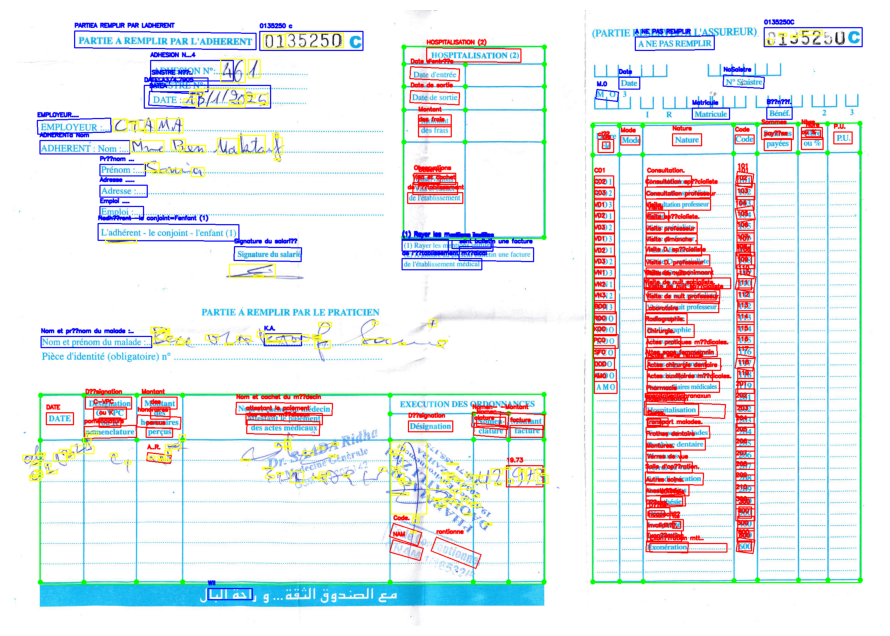

[INFO] Données combinées sauvegardées dans combined_layout.json


In [2]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
from paddleocr import PaddleOCR
import json

# Configuration OCR
OCR_ENGINE = PaddleOCR(
    use_angle_cls=True,
    lang="fr",
    use_gpu=False,
    det_db_thresh=0.4,
    det_db_box_thresh=0.5,
    det_db_unclip_ratio=2.0,
    rec_algorithm="SVTR_LCNet",
    max_text_length=100,
)

# -------- FONCTIONS DE DÉTECTION DE TABLEAUX --------
def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
        )
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blocksize,
            c,
        )
    return img, threshold

def find_lines(threshold, regions=None, direction="horizontal", line_scale=15, iterations=0):
    lines = []
    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    else:
        raise ValueError("Direction doit être 'vertical' ou 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y:y + h, x:x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))
    return dmask, lines

def find_contours(vertical, horizontal):
    mask = vertical + horizontal
    try:
        _, contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont, mask

def find_joints(contours, vertical, horizontal):
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y:y + h, x:x + w]
        try:
            _, jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        except ValueError:
            jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        if len(jc) <= 4:
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y + h, x + w, y)] = joint_coords
    return tables

# -------- FONCTIONS D'EXTRACTION DES CHAMPS --------
def contains_arabic(text):
    return bool(re.search("[\u0600-\u06FF]", text))

def is_likely_handwritten(text, box, image):
    width = box[2][0] - box[0][0]
    height = box[2][1] - box[0][1]
    aspect_ratio = width / height if height > 0 else 0
    if aspect_ratio < 0.5 or aspect_ratio > 10 or len(text) < 3:
        return True
    return False

def is_likely_field_name(text):
    text = text.strip().upper()
    word_count = len(text.split())
    if word_count > 6:
        return False

    field_keywords = [
        "NOM", "PRENOM", "ADRESSE", "MATRICULE", "DATE", "MONTANT", "CODE",
        "VISA", "HONORAIRES", "DESIGNATION", "TOTAL", "OBSERVATIONS", "FRAIS",
        "NUMERO", "SIGNATURE", "RESERVE", "SORTIE", "ENTREE", "MATRICULE FISCAL"
    ]
    if any(keyword in text for keyword in field_keywords):
        return True

    non_field_patterns = [
        r"BULLETIN DE SOINS",
        r"RESERVE A L'ETABLISSEMENT HOSPITALIER",
        r"RESERVE A STAR",
        r"RESERVE AUX MEDECINS ET PRATICIENS",
        r"POUR LES CHIRURGIES OU DE TRAITEMENTS SPECIAUX",
        r"IL FAUT JOINDRE AU BULLETIN DE SOINS"
    ]
    if any(re.search(pattern, text, re.IGNORECASE) for pattern in non_field_patterns):
        return False

    if len(text) > 50:
        return False

    return True

def preprocess_image(image, mode):
    image_np = np.array(image)
    if mode == "grayscale":
        return cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    elif mode == "rgb":
        return image_np
    elif mode == "binary":
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -2
        )
    elif mode == "contrast":
        img_lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img_lab = cv2.merge((l, a, b))
        return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError(f"Mode {mode} non supporté.")

def boxes_overlap(box1, box2, threshold=0.5):
    """Vérifie si deux boîtes se chevauchent (IoU).
    - box1: Liste de 4 points [[x1, y1], [x2, y1], [x2, y2], [x1, y2]] (texte tapé).
    - box2: Peut être soit [[x1, y1], [x2, y1], [x2, y2], [x1, y2]] (OCR), soit [x1, y1, x2, y2] (manuscrit).
    """
    # Normaliser box1 (toujours au format OCR)
    x1 = min(point[0] for point in box1)
    y1 = min(point[1] for point in box1)
    x2 = max(point[0] for point in box1)
    y2 = max(point[1] for point in box1)

    # Normaliser box2 (gérer les deux formats possibles)
    if len(box2) == 4 and isinstance(box2[0], list):  # Format OCR
        x1_p = min(point[0] for point in box2)
        y1_p = min(point[1] for point in box2)
        x2_p = max(point[0] for point in box2)
        y2_p = max(point[1] for point in box2)
    else:  # Format manuscrit [x1, y1, x2, y2]
        x1_p, y1_p, x2_p, y2_p = box2

    # Calcul de l'intersection
    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    # Calcul des aires
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou > threshold

def extract_text_and_layout(image):
    modes = ["grayscale", "rgb", "binary", "contrast"]
    extracted_data = []

    for mode in modes:
        print(f"[INFO] Application de l'OCR avec le mode {mode}")
        preprocessed_img = preprocess_image(image, mode)
        results = OCR_ENGINE.ocr(preprocessed_img, cls=True)

        if results is None:
            continue
        for line in results:
            if line is None:
                continue
            for word_info in line:
                if word_info is None:
                    continue
                text = word_info[1][0]
                confidence = word_info[1][1]
                box = word_info[0]

                text = text.replace("??", "é").replace("??", "à").strip()

                if confidence < 0.7:
                    continue
                if contains_arabic(text):
                    continue
                if is_likely_handwritten(text, box, preprocessed_img):
                    continue
                if len(text) < 2:
                    continue

                overlaps = False
                for existing in extracted_data:
                    if boxes_overlap(existing["box"], box):
                        overlaps = True
                        break

                if not overlaps:
                    extracted_data.append({"text": text, "box": box})

    print(f"[INFO] Nombre total de boîtes détectées : {len(extracted_data)}")
    return extracted_data

def filter_field_names(extracted_data):
    filtered_data = []
    for item in extracted_data:
        text = item["text"]
        if is_likely_field_name(text):
            filtered_data.append(item)
    return filtered_data

# -------- FONCTIONS POUR TEXTE MANUSCRIT --------
def thresholding(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 80, 255, cv2.THRESH_BINARY_INV)
    return thresh

def detect_handwritten_text(image, thresh_img):
    kernel = np.ones((3, 85), np.uint8)  # Pour lignes
    dilated = cv2.dilate(thresh_img, kernel, iterations=1)
    (contours, _) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1])

    kernel2 = np.ones((3, 15), np.uint8)  # Pour mots
    dilated2 = cv2.dilate(thresh_img, kernel2, iterations=1)
    words_list = []

    for line in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(line)
        roi_line = dilated2[y:y+h, x:x+w]
        (cnt, _) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        sorted_contour_words = sorted(cnt, key=lambda cntr: cv2.boundingRect(cntr)[0])

        for word in sorted_contour_words:
            if cv2.contourArea(word) < 50:  # Filtrer petits contours
                continue
            x2, y2, w2, h2 = cv2.boundingRect(word)
            words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
    return words_list

# -------- FONCTIONS D'ANNOTATION ET SAUVEGARDE --------
def is_inside_table(box, table_bbox):
    box_center_x = (box[0][0] + box[2][0]) / 2
    box_center_y = (box[0][1] + box[2][1]) / 2
    for key in table_bbox.keys():
        x1, y2, x2, y1 = key
        if x1 <= box_center_x <= x2 and y1 <= box_center_y <= y2:
            return True
    return False

def annotate_combined_image(image_path, table_bbox, typed_text_data, handwritten_boxes, output_path="combined_result.jpg"):
    image = cv2.imread(image_path)
    if image is None:
        print("[ERROR] Impossible de charger l'image pour l'annotation.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Tableaux (vert)
    for tab in table_bbox.keys():
        x1, y2, x2, y1 = tab
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        for cord in table_bbox[tab]:
            image = cv2.circle(image, (cord[0], cord[1]), radius=7, color=(0, 255, 0), thickness=-1)

    # Texte tapé (bleu hors tableaux, rouge dans tableaux)
    for item in typed_text_data:
        box = np.array(item["box"], np.int32).reshape((-1, 1, 2))
        color = (255, 0, 0) if is_inside_table(item["box"], table_bbox) else (0, 0, 255)
        cv2.polylines(image, [box], isClosed=True, color=color, thickness=2)
        text_x, text_y = box[0][0][0], box[0][0][1] - 10
        cv2.putText(image, item["text"], (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

    # Texte manuscrit (jaune)
    for box in handwritten_boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)

    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def save_combined_data(table_bbox, typed_text_data, handwritten_boxes, filename="combined_layout.json"):
    """Sauvegarde les données combinées dans un fichier JSON."""
    # Convertir les clés de table_bbox (tuples) en chaînes
    serializable_table_bbox = {str(key): value for key, value in table_bbox.items()}
    
    combined_data = {
        "tables": serializable_table_bbox,
        "typed_text": typed_text_data,
        "handwritten_text": handwritten_boxes
    }
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(combined_data, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Données combinées sauvegardées dans {filename}")

# -------- FONCTION PRINCIPALE --------
def main(doc_path):
    # Étape 1 : Préparation de l'image et détection des tableaux
    img, threshold = adaptive_threshold(doc_path, process_background=False, blocksize=15, c=-2)
    vertical_mask, vertical_segments = find_lines(threshold, direction="vertical", line_scale=15, iterations=0)
    horizontal_mask, horizontal_segments = find_lines(threshold, direction="horizontal", line_scale=15, iterations=0)
    contours, mask = find_contours(vertical_mask, horizontal_mask)
    table_bbox = find_joints(contours, vertical_mask, horizontal_mask)

    # Filtrer les tableaux trop grands
    image_height, image_width = img.shape[:2]
    image_area = image_height * image_width
    threshold_area_ratio = 0.9
    filtered_table_bbox = {}
    for tab, joints in table_bbox.items():
        x1, y2, x2, y1 = tab
        table_area = (x2 - x1) * (y2 - y1)
        if table_area / image_area < threshold_area_ratio:
            filtered_table_bbox[tab] = joints
    table_bbox = filtered_table_bbox

    # Étape 2 : Extraction du texte tapé avec OCR
    image_pil = Image.open(doc_path).convert("RGB")
    extracted_data = extract_text_and_layout(image_pil)
    typed_text_data = filter_field_names(extracted_data)

    # Étape 3 : Détection du texte manuscrit
    thresh_img = thresholding(img)
    handwritten_boxes = detect_handwritten_text(img, thresh_img)

    # Étape 4 : Filtrer les chevauchements entre texte tapé et manuscrit
    final_handwritten_boxes = []
    for h_box in handwritten_boxes:
        overlap = False
        for t_item in typed_text_data:
            t_box = t_item["box"]
            if boxes_overlap(t_box, h_box):
                overlap = True
                break
        if not overlap:
            final_handwritten_boxes.append(h_box)

    # Étape 5 : Annoter l'image combinée
    annotate_combined_image(doc_path, table_bbox, typed_text_data, final_handwritten_boxes)

    # Étape 6 : Sauvegarder les données combinées
    save_combined_data(table_bbox, typed_text_data, final_handwritten_boxes)

if __name__ == "__main__":
    document_path = r"C:\Users\jlassi\Desktop\testYolo\notebooks\BS__2025_01_06-2.png"
    main(document_path)

[2025/04/12 13:12:02] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.4, det_db_box_thresh=0.5, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

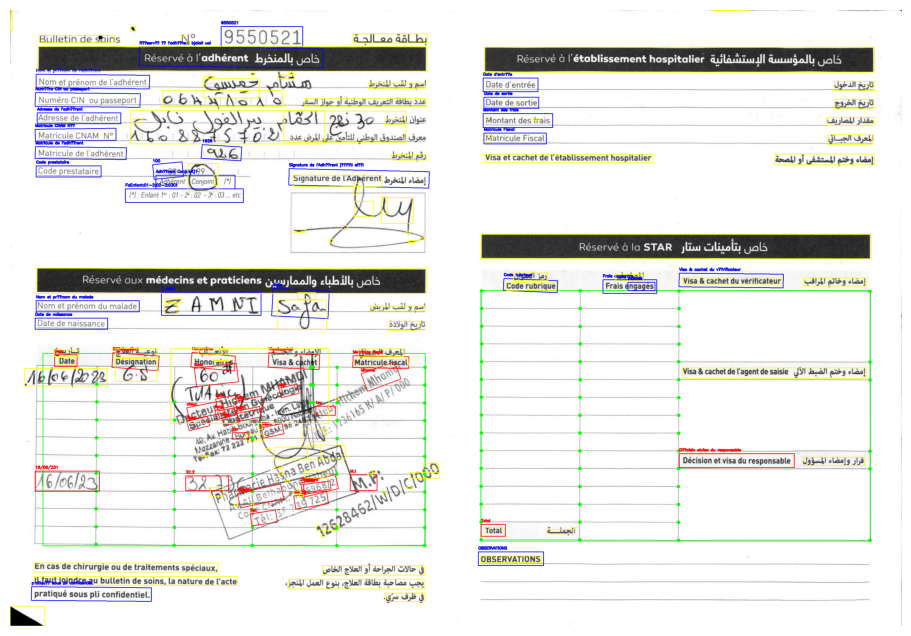

[INFO] Données combinées sauvegardées dans combined_layout.json


In [11]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
from paddleocr import PaddleOCR
import json

# Configuration OCR
OCR_ENGINE = PaddleOCR(
    use_angle_cls=True,
    lang="fr",
    use_gpu=False,
    det_db_thresh=0.4,
    det_db_box_thresh=0.5,
    det_db_unclip_ratio=2.0,
    rec_algorithm="SVTR_LCNet",
    max_text_length=100,
)

# -------- FONCTIONS DE DÉTECTION DE TABLEAUX --------
def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
        )
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blocksize,
            c,
        )
    return img, threshold

def find_lines(threshold, regions=None, direction="horizontal", line_scale=15, iterations=0):
    lines = []
    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    else:
        raise ValueError("Direction doit être 'vertical' ou 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y:y + h, x:x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))
    return dmask, lines

def find_contours(vertical, horizontal):
    mask = vertical + horizontal
    try:
        _, contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont, mask

def find_joints(contours, vertical, horizontal):
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y:y + h, x:x + w]
        try:
            _, jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        except ValueError:
            jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        if len(jc) <= 4:
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y + h, x + w, y)] = joint_coords
    return tables

# -------- FONCTIONS D'EXTRACTION DES CHAMPS --------
def contains_arabic(text):
    return bool(re.search("[\u0600-\u06FF]", text))

def is_likely_handwritten(text, box, image):
    width = box[2][0] - box[0][0]
    height = box[2][1] - box[0][1]
    aspect_ratio = width / height if height > 0 else 0
    if aspect_ratio < 0.5 or aspect_ratio > 10 or len(text) < 3:
        return True
    return False

def is_likely_field_name(text):
    text = text.strip().upper()
    word_count = len(text.split())
    if word_count > 6:
        return False

    field_keywords = [
        "NOM", "PRENOM", "ADRESSE", "MATRICULE", "DATE", "MONTANT", "CODE",
        "VISA", "HONORAIRES", "DESIGNATION", "TOTAL", "OBSERVATIONS", "FRAIS",
        "NUMERO", "SIGNATURE", "RESERVE", "SORTIE", "ENTREE", "MATRICULE FISCAL"
    ]
    if any(keyword in text for keyword in field_keywords):
        return True

    non_field_patterns = [
        r"BULLETIN DE SOINS",
        r"RESERVE A L'ETABLISSEMENT HOSPITALIER",
        r"RESERVE A STAR",
        r"RESERVE AUX MEDECINS ET PRATICIENS",
        r"POUR LES CHIRURGIES OU DE TRAITEMENTS SPECIAUX",
        r"IL FAUT JOINDRE AU BULLETIN DE SOINS"
    ]
    if any(re.search(pattern, text, re.IGNORECASE) for pattern in non_field_patterns):
        return False

    if len(text) > 50:
        return False

    return True

def preprocess_image(image, mode):
    image_np = np.array(image)
    if mode == "grayscale":
        return cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    elif mode == "rgb":
        return image_np
    elif mode == "binary":
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -2
        )
    elif mode == "contrast":
        img_lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img_lab = cv2.merge((l, a, b))
        return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError(f"Mode {mode} non supporté.")

def boxes_overlap(box1, box2, threshold=0.5):
    x1 = min(point[0] for point in box1)
    y1 = min(point[1] for point in box1)
    x2 = max(point[0] for point in box1)
    y2 = max(point[1] for point in box1)

    if len(box2) == 4 and isinstance(box2[0], list):
        x1_p = min(point[0] for point in box2)
        y1_p = min(point[1] for point in box2)
        x2_p = max(point[0] for point in box2)
        y2_p = max(point[1] for point in box2)
    else:
        x1_p, y1_p, x2_p, y2_p = box2

    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou > threshold

def extract_text_and_layout(image):
    modes = ["grayscale", "rgb", "binary", "contrast"]
    extracted_data = []

    for mode in modes:
        print(f"[INFO] Application de l'OCR avec le mode {mode}")
        preprocessed_img = preprocess_image(image, mode)
        results = OCR_ENGINE.ocr(preprocessed_img, cls=True)

        if results is None:
            continue
        for line in results:
            if line is None:
                continue
            for word_info in line:
                if word_info is None:
                    continue
                text = word_info[1][0]
                confidence = word_info[1][1]
                box = word_info[0]

                text = text.replace("??", "é").replace("??", "à").strip()

                if confidence < 0.7:
                    continue
                if contains_arabic(text):
                    continue
                if is_likely_handwritten(text, box, preprocessed_img):
                    continue
                if len(text) < 2:
                    continue

                overlaps = False
                for existing in extracted_data:
                    if boxes_overlap(existing["box"], box):
                        overlaps = True
                        break

                if not overlaps:
                    extracted_data.append({"text": text, "box": box})

    print(f"[INFO] Nombre total de boîtes détectées : {len(extracted_data)}")
    return extracted_data

def filter_field_names(extracted_data):
    filtered_data = []
    for item in extracted_data:
        text = item["text"]
        if is_likely_field_name(text):
            filtered_data.append(item)
    return filtered_data

# -------- FONCTIONS POUR TEXTE MANUSCRIT --------
def thresholding(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 80, 255, cv2.THRESH_BINARY_INV)
    return thresh

def merge_boxes_in_line(boxes, horizontal_threshold=50):
    """
    Merge boxes within the same line based on horizontal proximity.
    boxes: List of [x1, y1, x2, y2]
    horizontal_threshold: Maximum horizontal gap to merge boxes
    Returns: A single merged box [x1, y1, x2, y2]
    """
    if not boxes:
        return None

    # Sort boxes by x1 (left to right)
    boxes = sorted(boxes, key=lambda x: x[0])
    merged_boxes = []
    current_group = [boxes[0]]

    for box in boxes[1:]:
        last_box = current_group[-1]
        x1, y1, x2, y2 = box
        lx1, ly1, lx2, ly2 = last_box

        # Check if boxes are close horizontally
        horizontal_distance = x1 - lx2
        if horizontal_distance <= horizontal_threshold:
            current_group.append(box)
        else:
            # Merge the current group
            min_x = min(b[0] for b in current_group)
            min_y = min(b[1] for b in current_group)
            max_x = max(b[2] for b in current_group)
            max_y = max(b[3] for b in current_group)
            merged_boxes.append([min_x, min_y, max_x, max_y])
            current_group = [box]

    # Merge the last group
    if current_group:
        min_x = min(b[0] for b in current_group)
        min_y = min(b[1] for b in current_group)
        max_x = max(b[2] for b in current_group)
        max_y = max(b[3] for b in current_group)
        merged_boxes.append([min_x, min_y, max_x, max_y])

    return merged_boxes[0] if merged_boxes else None

def detect_handwritten_text(image, thresh_img):
    # Step 1: Detect lines of handwritten text
    kernel_line = np.ones((5, 50), np.uint8)  # Kernel to detect lines
    dilated_lines = cv2.dilate(thresh_img, kernel_line, iterations=1)
    contours_lines, _ = cv2.findContours(dilated_lines.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours_lines = sorted(contours_lines, key=lambda ctr: cv2.boundingRect(ctr)[1])

    final_boxes = []

    # Step 2: For each line, detect smaller regions (words/characters) and merge them
    kernel_word = np.ones((3, 10), np.uint8)  # Smaller kernel for words/characters
    for line in sorted_contours_lines:
        if cv2.contourArea(line) < 100:  # Filter small contours
            continue
        x, y, w, h = cv2.boundingRect(line)
        # Expand the region slightly to ensure we capture the entire line
        padding = 5
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = w + 2 * padding
        h = h + 2 * padding
        roi_line = thresh_img[y:y+h, x:x+w]

        # Detect smaller regions within the line
        dilated_words = cv2.dilate(roi_line, kernel_word, iterations=1)
        contours_words, _ = cv2.findContours(dilated_words.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        sorted_contour_words = sorted(contours_words, key=lambda ctr: cv2.boundingRect(ctr)[0])

        # Collect boxes for this line
        line_boxes = []
        for word in sorted_contour_words:
            if cv2.contourArea(word) < 50:  # Filter small contours
                continue
            x2, y2, w2, h2 = cv2.boundingRect(word)
            # Adjust coordinates to the original image
            line_boxes.append([x + x2, y + y2, x + x2 + w2, y + y2 + h2])

        # Merge boxes within the line
        if line_boxes:
            merged_box = merge_boxes_in_line(line_boxes, horizontal_threshold=50)
            if merged_box:
                final_boxes.append(merged_box)

    return final_boxes

# -------- FONCTIONS D'ANNOTATION ET SAUVEGARDE --------
def is_inside_table(box, table_bbox):
    box_center_x = (box[0][0] + box[2][0]) / 2
    box_center_y = (box[0][1] + box[2][1]) / 2
    for key in table_bbox.keys():
        x1, y2, x2, y1 = key
        if x1 <= box_center_x <= x2 and y1 <= box_center_y <= y2:
            return True
    return False

def annotate_combined_image(image_path, table_bbox, typed_text_data, handwritten_boxes, output_path="combined_result.jpg"):
    image = cv2.imread(image_path)
    if image is None:
        print("[ERROR] Impossible de charger l'image pour l'annotation.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Tableaux (vert)
    for tab in table_bbox.keys():
        x1, y2, x2, y1 = tab
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        for cord in table_bbox[tab]:
            image = cv2.circle(image, (cord[0], cord[1]), radius=7, color=(0, 255, 0), thickness=-1)

    # Texte tapé (bleu hors tableaux, rouge dans tableaux)
    for item in typed_text_data:
        box = np.array(item["box"], np.int32).reshape((-1, 1, 2))
        color = (255, 0, 0) if is_inside_table(item["box"], table_bbox) else (0, 0, 255)
        cv2.polylines(image, [box], isClosed=True, color=color, thickness=2)
        text_x, text_y = box[0][0][0], box[0][0][1] - 10
        cv2.putText(image, item["text"], (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

    # Texte manuscrit (jaune)
    for box in handwritten_boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)

    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def save_combined_data(table_bbox, typed_text_data, handwritten_boxes, filename="combined_layout.json"):
    serializable_table_bbox = {str(key): value for key, value in table_bbox.items()}
    
    combined_data = {
        "tables": serializable_table_bbox,
        "typed_text": typed_text_data,
        "handwritten_text": handwritten_boxes
    }
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(combined_data, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Données combinées sauvegardées dans {filename}")

# -------- FONCTION PRINCIPALE --------
def main(doc_path):
    # Étape 1 : Préparation de l'image et détection des tableaux
    img, threshold = adaptive_threshold(doc_path, process_background=False, blocksize=15, c=-2)
    vertical_mask, vertical_segments = find_lines(threshold, direction="vertical", line_scale=15, iterations=0)
    horizontal_mask, horizontal_segments = find_lines(threshold, direction="horizontal", line_scale=15, iterations=0)
    contours, mask = find_contours(vertical_mask, horizontal_mask)
    table_bbox = find_joints(contours, vertical_mask, horizontal_mask)

    # Filtrer les tableaux trop grands
    image_height, image_width = img.shape[:2]
    image_area = image_height * image_width
    threshold_area_ratio = 0.9
    filtered_table_bbox = {}
    for tab, joints in table_bbox.items():
        x1, y2, x2, y1 = tab
        table_area = (x2 - x1) * (y2 - y1)
        if table_area / image_area < threshold_area_ratio:
            filtered_table_bbox[tab] = joints
    table_bbox = filtered_table_bbox

    # Étape 2 : Extraction du texte tapé avec OCR
    image_pil = Image.open(doc_path).convert("RGB")
    extracted_data = extract_text_and_layout(image_pil)
    typed_text_data = filter_field_names(extracted_data)

    # Étape 3 : Détection du texte manuscrit
    thresh_img = thresholding(img)
    handwritten_boxes = detect_handwritten_text(img, thresh_img)

    # Étape 4 : Filtrer les chevauchements entre texte tapé et manuscrit
    final_handwritten_boxes = []
    for h_box in handwritten_boxes:
        overlap = False
        for t_item in typed_text_data:
            t_box = t_item["box"]
            if boxes_overlap(t_box, h_box):
                overlap = True
                break
        if not overlap:
            final_handwritten_boxes.append(h_box)

    # Étape 5 : Annoter l'image combinée
    annotate_combined_image(doc_path, table_bbox, typed_text_data, final_handwritten_boxes)

    # Étape 6 : Sauvegarder les données combinées
    save_combined_data(table_bbox, typed_text_data, final_handwritten_boxes)

if __name__ == "__main__":
    document_path = r"C:\Users\jlassi\Desktop\testYolo\notebooks\image.png"
    main(document_path)

[2025/04/12 22:30:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.4, det_db_box_thresh=0.5, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

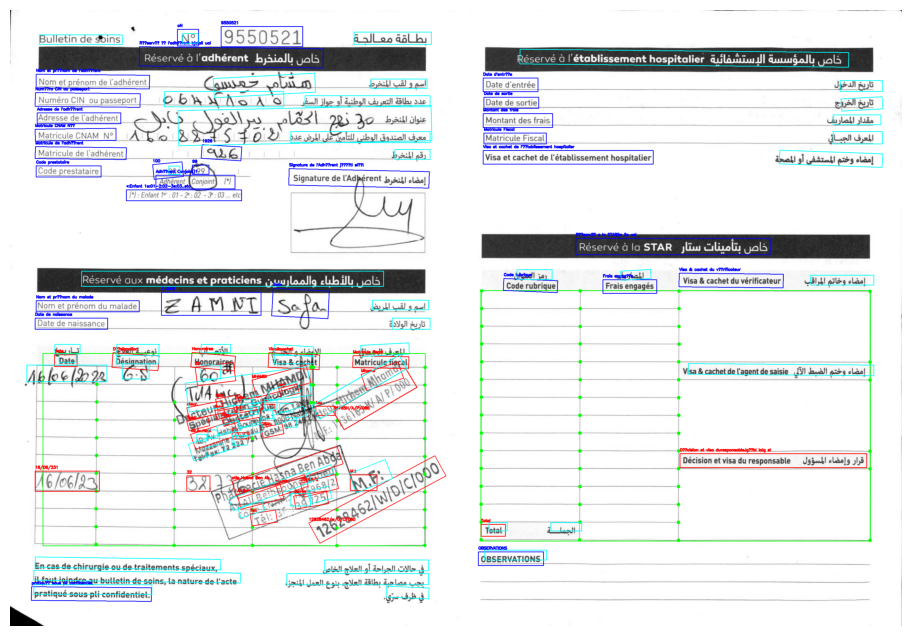

[INFO] Données combinées sauvegardées dans combined_layout.json


In [17]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
from paddleocr import PaddleOCR
import json
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions
)

# Configuration OCR
OCR_ENGINE = PaddleOCR(
    use_angle_cls=True,
    lang="fr",
    use_gpu=False,
    det_db_thresh=0.4,
    det_db_box_thresh=0.5,
    det_db_unclip_ratio=2.0,
    rec_algorithm="SVTR_LCNet",
    max_text_length=100,
)

# Configuration CRAFT
CRAFT_LONG_SIZE = 1280

# Paramètres de filtrage
MIN_BOX_WIDTH = 15  # Largeur minimale d'une boîte
MIN_BOX_HEIGHT = 10  # Hauteur minimale d'une boîte
MIN_BOX_AREA = 150  # Aire minimale d'une boîte (width * height)

# -------- FONCTIONS DE DÉTECTION DE TABLEAUX --------
def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
        )
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blocksize,
            c,
        )
    return img, threshold

def find_lines(threshold, regions=None, direction="horizontal", line_scale=15, iterations=0):
    lines = []
    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    else:
        raise ValueError("Direction doit être 'vertical' ou 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y:y + h, x:x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))
    return dmask, lines

def find_contours(vertical, horizontal):
    mask = vertical + horizontal
    try:
        _, contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont, mask

def find_joints(contours, vertical, horizontal):
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y:y + h, x:x + w]
        try:
            _, jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        except ValueError:
            jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        if len(jc) <= 4:
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y + h, x + w, y)] = joint_coords
    return tables

# -------- FONCTIONS D'EXTRACTION DES CHAMPS --------
def contains_arabic(text):
    return bool(re.search("[\u0600-\u06FF]", text))

def is_likely_field_name(text):
    text = text.strip().upper()
    word_count = len(text.split())
    if word_count > 6:
        return False

    field_keywords = [
        "NOM", "PRENOM", "ADRESSE", "MATRICULE", "DATE", "MONTANT", "CODE",
        "VISA", "HONORAIRES", "DESIGNATION", "TOTAL", "OBSERVATIONS", "FRAIS",
        "NUMERO", "SIGNATURE", "RESERVE", "SORTIE", "ENTREE", "MATRICULE FISCAL"
    ]
    if any(keyword in text for keyword in field_keywords):
        return True

    non_field_patterns = [
        r"BULLETIN DE SOINS",
        r"RESERVE A L'ETABLISSEMENT HOSPITALIER",
        r"RESERVE A STAR",
        r"RESERVE AUX MEDECINS ET PRATICIENS",
        r"POUR LES CHIRURGIES OU DE TRAITEMENTS SPECIAUX",
        r"IL FAUT JOINDRE AU BULLETIN DE SOINS"
    ]
    if any(re.search(pattern, text, re.IGNORECASE) for pattern in non_field_patterns):
        return False

    if len(text) > 50:
        return False

    return True

def preprocess_image(image, mode):
    image_np = np.array(image)
    if mode == "grayscale":
        return cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    elif mode == "rgb":
        return image_np
    elif mode == "binary":
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -2
        )
    elif mode == "contrast":
        img_lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img_lab = cv2.merge((l, a, b))
        return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError(f"Mode {mode} non supporté.")

def get_box_size(box):
    """Calcule la largeur, hauteur et aire d'une boîte"""
    if isinstance(box, list):
        # Format PaddleOCR: liste de 4 points [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
        x_coords = [point[0] for point in box]
        y_coords = [point[1] for point in box]
        width = max(x_coords) - min(x_coords)
        height = max(y_coords) - min(y_coords)
    else:
        # Format CRAFT: array numpy de shape (4,2)
        x_coords = box[:, 0]
        y_coords = box[:, 1]
        width = x_coords.max() - x_coords.min()
        height = y_coords.max() - y_coords.min()
    
    area = width * height
    return width, height, area

def is_valid_box(box):
    """Vérifie si une boîte est assez grande"""
    width, height, area = get_box_size(box)
    return (width >= MIN_BOX_WIDTH and 
            height >= MIN_BOX_HEIGHT and 
            area >= MIN_BOX_AREA)

def boxes_overlap(box1, box2, threshold=0.5):
    """Vérifie si deux boîtes se chevauchent."""
    # Convertir box1 en coordonnées min/max
    if isinstance(box1, list):
        x1 = min(point[0] for point in box1)
        y1 = min(point[1] for point in box1)
        x2 = max(point[0] for point in box1)
        y2 = max(point[1] for point in box1)
    else:
        x1, y1 = box1.min(axis=0)
        x2, y2 = box1.max(axis=0)

    # Convertir box2 en coordonnées min/max
    if isinstance(box2, list):
        x1_p = min(point[0] for point in box2)
        y1_p = min(point[1] for point in box2)
        x2_p = max(point[0] for point in box2)
        y2_p = max(point[1] for point in box2)
    else:
        x1_p, y1_p = box2.min(axis=0)
        x2_p, y2_p = box2.max(axis=0)

    # Calcul de l'intersection
    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou > threshold

def extract_text_and_layout(image):
    modes = ["rgb", "contrast"]
    extracted_data = []

    for mode in modes:
        print(f"[INFO] Application de l'OCR avec le mode {mode}")
        preprocessed_img = preprocess_image(image, mode)
        results = OCR_ENGINE.ocr(preprocessed_img, cls=True)

        if results is None:
            continue
        for line in results:
            if line is None:
                continue
            for word_info in line:
                if word_info is None:
                    continue
                text = word_info[1][0]
                confidence = word_info[1][1]
                box = word_info[0]

                text = text.replace("??", "é").replace("??", "à").strip()

                if confidence < 0.7:
                    continue
                if contains_arabic(text):
                    continue
                if len(text) < 2:
                    continue
                if not is_valid_box(box):  # Filtre les boîtes trop petites
                    continue

                overlaps = False
                for existing in extracted_data:
                    if boxes_overlap(existing["box"], box):
                        overlaps = True
                        break

                if not overlaps:
                    extracted_data.append({"text": text, "box": box, "source": "paddle"})

    print(f"[INFO] Nombre total de boîtes détectées : {len(extracted_data)}")
    return extracted_data

def filter_field_names(extracted_data):
    filtered_data = []
    for item in extracted_data:
        text = item["text"]
        if is_likely_field_name(text):
            filtered_data.append(item)
    return filtered_data

def ultra_precise_adjustment(boxes, original_size, network_size, long_size):
    """
    Correction de positionnement ultra-précise avec :
    - Prise en compte du ratio d'aspect
    - Correction différentielle X/Y
    - Vérification des bords
    """
    orig_h, orig_w = original_size
    net_h, net_w = network_size
    
    # Calcul des ratios de base
    scale_x = orig_w / net_w
    scale_y = orig_h / net_h
    
    # Facteur de correction basé sur long_size
    size_ratio = long_size / max(net_w, net_h)
    
    # Correction différentielle X/Y
    aspect_ratio_correction = np.sqrt((scale_x * scale_y) / (size_ratio**2))
    
    adjusted_boxes = []
    for box in boxes:
        box = np.array(box, dtype=np.float32)
        if box.shape != (4, 2):
            continue
            
        # Application du scaling avec correction
        box[:, 0] = box[:, 0] * scale_x / aspect_ratio_correction
        box[:, 1] = box[:, 1] * scale_y / aspect_ratio_correction
        
        # Ajustement final millimétrique (optionnel)
        box[:, 0] *= 1.0015  # Ajuster selon besoin
        box[:, 1] *= 0.9985  # Ajuster selon besoin
        
        # Garantie des limites
        box[:, 0] = np.clip(box[:, 0], 0, orig_w - 1)
        box[:, 1] = np.clip(box[:, 1], 0, orig_h - 1)
        
        adjusted_boxes.append(box)
    
    return adjusted_boxes

def detect_text_with_craft(image_path, existing_boxes):
    # Charger l'image originale
    original_image = read_image(image_path)
    orig_h, orig_w = original_image.shape[:2]
    
    # Charger les modèles CRAFT
    craft_net = load_craftnet_model(cuda=False)
    refine_net = load_refinenet_model(cuda=False)
    
    # Faire la prédiction
    prediction_result = get_prediction(
        image=original_image,
        craft_net=craft_net,
        refine_net=refine_net,
        text_threshold=0.7,
        link_threshold=0.45,
        low_text=0.4,
        cuda=False,
        long_size=CRAFT_LONG_SIZE,
        poly=False
    )
    
    # Récupérer les dimensions réelles
    score_map = prediction_result["heatmaps"]["text_score_heatmap"]
    net_h, net_w = score_map.shape[:2]
    
    # Filtrage des boîtes
    raw_boxes = prediction_result["boxes"]
    valid_boxes = [b for b in raw_boxes if isinstance(b, np.ndarray) and b.shape == (4, 2)]
    
    craft_data = []
    
    if valid_boxes:
        # Correction ultra-précise
        final_boxes = ultra_precise_adjustment(
            valid_boxes,
            (orig_h, orig_w),
            (net_h, net_w),
            CRAFT_LONG_SIZE
        )
        
        # Filtrer les boîtes qui chevauchent celles détectées par PaddleOCR
        for box in final_boxes:
            # Vérifier si la boîte est assez grande
            if not is_valid_box(box):
                continue
                
            overlaps = False
            for existing in existing_boxes:
                if boxes_overlap(existing["box"], box):
                    overlaps = True
                    break
            
            if not overlaps:
                # Convertir le format de la boîte pour être cohérent avec PaddleOCR
                box_points = box.tolist()
                craft_data.append({
                    "box": box_points,
                    "text": "",  # Le texte sera extrait plus tard
                    "source": "craft"
                })
    
    return craft_data

# -------- FONCTIONS D'ANNOTATION ET SAUVEGARDE --------
def is_inside_table(box, table_bbox):
    box_center_x = (box[0][0] + box[2][0]) / 2
    box_center_y = (box[0][1] + box[2][1]) / 2
    for key in table_bbox.keys():
        x1, y2, x2, y1 = key
        if x1 <= box_center_x <= x2 and y1 <= box_center_y <= y2:
            return True
    return False

def annotate_combined_image(image_path, table_bbox, typed_text_data, output_path="combined_result.jpg"):
    image = cv2.imread(image_path)
    if image is None:
        print("[ERROR] Impossible de charger l'image pour l'annotation.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Tableaux (vert)
    for tab in table_bbox.keys():
        x1, y2, x2, y1 = tab
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        for cord in table_bbox[tab]:
            image = cv2.circle(image, (cord[0], cord[1]), radius=7, color=(0, 255, 0), thickness=-1)

    # Texte tapé (bleu hors tableaux, rouge dans tableaux)
    for item in typed_text_data:
        box = np.array(item["box"], np.int32).reshape((-1, 1, 2))
        color = (255, 0, 0) if is_inside_table(item["box"], table_bbox) else (0, 0, 255)
        source = item.get("source", "paddle")
        if source == "craft":
            color = (0, 255, 255)  # Cyan clair pour CRAFT (BGR)
        cv2.polylines(image, [box], isClosed=True, color=color, thickness=2)
        text_x, text_y = box[0][0][0], box[0][0][1] - 10
        cv2.putText(image, item["text"], (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def save_combined_data(table_bbox, typed_text_data, filename="combined_layout.json"):
    serializable_table_bbox = {str(key): value for key, value in table_bbox.items()}
    
    combined_data = {
        "tables": serializable_table_bbox,
        "typed_text": typed_text_data
    }
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(combined_data, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Données combinées sauvegardées dans {filename}")

# -------- FONCTION PRINCIPALE --------
def main(doc_path):
    # Étape 1 : Préparation de l'image et détection des tableaux
    img, threshold = adaptive_threshold(doc_path, process_background=False, blocksize=15, c=-2)
    vertical_mask, vertical_segments = find_lines(threshold, direction="vertical", line_scale=15, iterations=0)
    horizontal_mask, horizontal_segments = find_lines(threshold, direction="horizontal", line_scale=15, iterations=0)
    contours, mask = find_contours(vertical_mask, horizontal_mask)
    table_bbox = find_joints(contours, vertical_mask, horizontal_mask)

    # Filtrer les tableaux trop grands
    image_height, image_width = img.shape[:2]
    image_area = image_height * image_width
    threshold_area_ratio = 0.9
    filtered_table_bbox = {}
    for tab, joints in table_bbox.items():
        x1, y2, x2, y1 = tab
        table_area = (x2 - x1) * (y2 - y1)
        if table_area / image_area < threshold_area_ratio:
            filtered_table_bbox[tab] = joints
    table_bbox = filtered_table_bbox

    # Étape 2 : Extraction du texte tapé avec PaddleOCR
    image_pil = Image.open(doc_path).convert("RGB")
    extracted_data = extract_text_and_layout(image_pil)
    typed_text_data = filter_field_names(extracted_data)

    # Étape 3 : Détection de texte supplémentaire avec CRAFT
    craft_data = detect_text_with_craft(doc_path, typed_text_data)
    
    # Combiner les résultats en donnant la priorité à PaddleOCR
    combined_text_data = typed_text_data + craft_data

    # Étape 4 : Annoter l'image combinée
    annotate_combined_image(doc_path, table_bbox, combined_text_data)

    # Étape 5 : Sauvegarder les données combinées
    save_combined_data(table_bbox, combined_text_data)

if __name__ == "__main__":
    document_path = r"C:\Users\jlassi\Desktop\testYolo\notebooks\image.png"
    main(document_path)

-----------------------------------------------------------------------------

In [1]:
import torch
print(torch.cuda.is_available())  # Doit retourner True
print(torch.cuda.device_count())  # Nombre de GPU disponibles
print(torch.cuda.get_device_name(0))  # Nom du GPU

True
1
NVIDIA GeForce RTX 3050 Laptop GPU


[2025/04/13 14:55:31] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.4, det_db_box_thresh=0.5, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

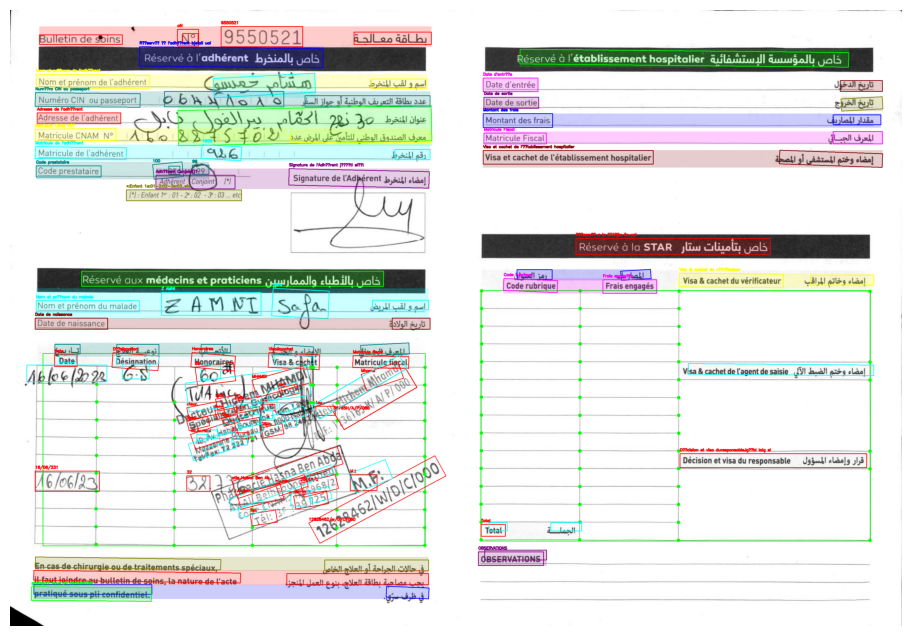

[INFO] Données combinées sauvegardées dans combined_layout.json


In [23]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
from paddleocr import PaddleOCR
import json
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions
)

# Configuration OCR
OCR_ENGINE = PaddleOCR(
    use_angle_cls=True,
    lang="fr",
    use_gpu=False,
    det_db_thresh=0.4,
    det_db_box_thresh=0.5,
    det_db_unclip_ratio=2.0,
    rec_algorithm="SVTR_LCNet",
    max_text_length=100,
)

# Configuration CRAFT
CRAFT_LONG_SIZE = 1280

# Paramètres de filtrage
MIN_BOX_WIDTH = 15
MIN_BOX_HEIGHT = 10
MIN_BOX_AREA = 150
LINE_HEIGHT_TOLERANCE = 15 
MIN_LINE_WIDTH = 50  

# -------- FONCTIONS DE DÉTECTION DE TABLEAUX --------
def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
        )
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blocksize,
            c,
        )
    return img, threshold

def find_lines(threshold, regions=None, direction="horizontal", line_scale=15, iterations=0):
    lines = []
    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    else:
        raise ValueError("Direction doit être 'vertical' ou 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y:y + h, x:x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))
    return dmask, lines

def find_contours(vertical, horizontal):
    mask = vertical + horizontal
    try:
        _, contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont, mask

def find_joints(contours, vertical, horizontal):
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y:y + h, x:x + w]
        try:
            _, jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        except ValueError:
            jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        if len(jc) <= 4:
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y + h, x + w, y)] = joint_coords
    return tables


def contains_arabic(text):
    return bool(re.search("[\u0600-\u06FF]", text))

def is_likely_field_name(text):
    text = text.strip().upper()
    word_count = len(text.split())
    if word_count > 6:
        return False

    field_keywords = [
        "NOM", "PRENOM", "ADRESSE", "MATRICULE", "DATE", "MONTANT", "CODE",
        "VISA", "HONORAIRES", "DESIGNATION", "TOTAL", "OBSERVATIONS", "FRAIS",
        "NUMERO", "SIGNATURE", "RESERVE", "SORTIE", "ENTREE", "MATRICULE FISCAL"
    ]
    if any(keyword in text for keyword in field_keywords):
        return True

    non_field_patterns = [
        r"BULLETIN DE SOINS",
        r"RESERVE A L'ETABLISSEMENT HOSPITALIER",
        r"RESERVE A STAR",
        r"RESERVE AUX MEDECINS ET PRATICIENS",
        r"POUR LES CHIRURGIES OU DE TRAITEMENTS SPECIAUX",
        r"IL FAUT JOINDRE AU BULLETIN DE SOINS"
    ]
    if any(re.search(pattern, text, re.IGNORECASE) for pattern in non_field_patterns):
        return False

    if len(text) > 50:
        return False

    return True

def preprocess_image(image, mode):
    image_np = np.array(image)
    if mode == "grayscale":
        return cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    elif mode == "rgb":
        return image_np
    elif mode == "binary":
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -2
        )
    elif mode == "contrast":
        img_lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img_lab = cv2.merge((l, a, b))
        return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError(f"Mode {mode} non supporté.")

def get_box_size(box):
    """Calcule la largeur, hauteur et aire d'une boîte"""
    if isinstance(box, list):
        # Format PaddleOCR: liste de 4 points [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
        x_coords = [point[0] for point in box]
        y_coords = [point[1] for point in box]
        width = max(x_coords) - min(x_coords)
        height = max(y_coords) - min(y_coords)
    else:
        # Format CRAFT: array numpy de shape (4,2)
        x_coords = box[:, 0]
        y_coords = box[:, 1]
        width = x_coords.max() - x_coords.min()
        height = y_coords.max() - y_coords.min()
    
    area = width * height
    return width, height, area

def is_valid_box(box):
    """Vérifie si une boîte est assez grande"""
    width, height, area = get_box_size(box)
    return (width >= MIN_BOX_WIDTH and 
            height >= MIN_BOX_HEIGHT and 
            area >= MIN_BOX_AREA)

def boxes_overlap(box1, box2, threshold=0.5):
    """Vérifie si deux boîtes se chevauchent."""
    # Convertir box1 en coordonnées min/max
    if isinstance(box1, list):
        x1 = min(point[0] for point in box1)
        y1 = min(point[1] for point in box1)
        x2 = max(point[0] for point in box1)
        y2 = max(point[1] for point in box1)
    else:
        x1, y1 = box1.min(axis=0)
        x2, y2 = box1.max(axis=0)

    # Convertir box2 en coordonnées min/max
    if isinstance(box2, list):
        x1_p = min(point[0] for point in box2)
        y1_p = min(point[1] for point in box2)
        x2_p = max(point[0] for point in box2)
        y2_p = max(point[1] for point in box2)
    else:
        x1_p, y1_p = box2.min(axis=0)
        x2_p, y2_p = box2.max(axis=0)

    # Calcul de l'intersection
    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou > threshold

def extract_text_and_layout(image):
    modes = ["rgb", "contrast"]
    extracted_data = []

    for mode in modes:
        print(f"[INFO] Application de l'OCR avec le mode {mode}")
        preprocessed_img = preprocess_image(image, mode)
        results = OCR_ENGINE.ocr(preprocessed_img, cls=True)

        if results is None:
            continue
        for line in results:
            if line is None:
                continue
            for word_info in line:
                if word_info is None:
                    continue
                text = word_info[1][0]
                confidence = word_info[1][1]
                box = word_info[0]

                text = text.replace("??", "é").replace("??", "à").strip()

                if confidence < 0.7:
                    continue
                if contains_arabic(text):
                    continue
                if len(text) < 2:
                    continue
                if not is_valid_box(box):  # Filtre les boîtes trop petites
                    continue

                overlaps = False
                for existing in extracted_data:
                    if boxes_overlap(existing["box"], box):
                        overlaps = True
                        break

                if not overlaps:
                    extracted_data.append({"text": text, "box": box, "source": "paddle"})

    print(f"[INFO] Nombre total de boîtes détectées : {len(extracted_data)}")
    return extracted_data

def filter_field_names(extracted_data):
    filtered_data = []
    for item in extracted_data:
        text = item["text"]
        if is_likely_field_name(text):
            filtered_data.append(item)
    return filtered_data

def ultra_precise_adjustment(boxes, original_size, network_size, long_size):
    """
    Correction de positionnement ultra-précise avec :
    - Prise en compte du ratio d'aspect
    - Correction différentielle X/Y
    - Vérification des bords
    """
    orig_h, orig_w = original_size
    net_h, net_w = network_size
    
    # Calcul des ratios de base
    scale_x = orig_w / net_w
    scale_y = orig_h / net_h
    
    # Facteur de correction basé sur long_size
    size_ratio = long_size / max(net_w, net_h)
    
    # Correction différentielle X/Y
    aspect_ratio_correction = np.sqrt((scale_x * scale_y) / (size_ratio**2))
    
    adjusted_boxes = []
    for box in boxes:
        box = np.array(box, dtype=np.float32)
        if box.shape != (4, 2):
            continue
            
        # Application du scaling avec correction
        box[:, 0] = box[:, 0] * scale_x / aspect_ratio_correction
        box[:, 1] = box[:, 1] * scale_y / aspect_ratio_correction
        
        # Ajustement final millimétrique (optionnel)
        box[:, 0] *= 1.0015  # Ajuster selon besoin
        box[:, 1] *= 0.9985  # Ajuster selon besoin
        
        # Garantie des limites
        box[:, 0] = np.clip(box[:, 0], 0, orig_w - 1)
        box[:, 1] = np.clip(box[:, 1], 0, orig_h - 1)
        
        adjusted_boxes.append(box)
    
    return adjusted_boxes

def detect_text_with_craft(image_path, existing_boxes):
    # Charger l'image originale
    original_image = read_image(image_path)
    orig_h, orig_w = original_image.shape[:2]
    
    # Charger les modèles CRAFT
    craft_net = load_craftnet_model(cuda=False)
    refine_net = load_refinenet_model(cuda=False)
    
    # Faire la prédiction
    prediction_result = get_prediction(
        image=original_image,
        craft_net=craft_net,
        refine_net=refine_net,
        text_threshold=0.7,
        link_threshold=0.45,
        low_text=0.4,
        cuda=False,
        long_size=CRAFT_LONG_SIZE,
        poly=False
    )
    
    # Récupérer les dimensions réelles
    score_map = prediction_result["heatmaps"]["text_score_heatmap"]
    net_h, net_w = score_map.shape[:2]
    
    # Filtrage des boîtes
    raw_boxes = prediction_result["boxes"]
    valid_boxes = [b for b in raw_boxes if isinstance(b, np.ndarray) and b.shape == (4, 2)]
    
    craft_data = []
    
    if valid_boxes:
        # Correction ultra-précise
        final_boxes = ultra_precise_adjustment(
            valid_boxes,
            (orig_h, orig_w),
            (net_h, net_w),
            CRAFT_LONG_SIZE
        )
        
        # Filtrer les boîtes qui chevauchent celles détectées par PaddleOCR
        for box in final_boxes:
            # Vérifier si la boîte est assez grande
            if not is_valid_box(box):
                continue
                
            overlaps = False
            for existing in existing_boxes:
                if boxes_overlap(existing["box"], box):
                    overlaps = True
                    break
            
            if not overlaps:
                # Convertir le format de la boîte pour être cohérent avec PaddleOCR
                box_points = box.tolist()
                craft_data.append({
                    "box": box_points,
                    "text": "",  # Le texte sera extrait plus tard
                    "source": "craft"
                })
    
    return craft_data


# -------- FONCTIONS UTILITAIRES --------
def get_box_rect(box):
    """Convertit une boîte en rectangle (x, y, w, h)"""
    if isinstance(box, list):
        x_coords = [point[0] for point in box]
        y_coords = [point[1] for point in box]
    else:
        x_coords = box[:, 0]
        y_coords = box[:, 1]
    
    x = min(x_coords)
    y = min(y_coords)
    w = max(x_coords) - x
    h = max(y_coords) - y
    return x, y, w, h

def is_valid_box(box):
    """Vérifie si une boîte est assez grande"""
    _, _, w, h = get_box_rect(box)
    area = w * h
    return (w >= MIN_BOX_WIDTH and 
            h >= MIN_BOX_HEIGHT and 
            area >= MIN_BOX_AREA)

def boxes_overlap(box1, box2, threshold=0.5):
    """Vérifie si deux boîtes se chevauchent."""
    x1, y1, w1, h1 = get_box_rect(box1)
    x2, y2, w2, h2 = get_box_rect(box2)
    
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou > threshold

def group_boxes_into_lines(boxes, image_width, tolerance=LINE_HEIGHT_TOLERANCE):
    """Regroupe les boîtes en lignes basées sur leur position verticale."""
    if not boxes:
        return []
    
    # Convertir toutes les boîtes en rectangles et calculer leur centre y
    box_rects = []
    for box in boxes:
        x, y, w, h = get_box_rect(box["box"])
        center_y = y + h/2
        box_rects.append((center_y, box))
    
    # Trier par position verticale
    box_rects.sort(key=lambda x: x[0])
    
    lines = []
    current_line = []
    current_ref_y = box_rects[0][0]
    
    for center_y, box in box_rects:
        if abs(center_y - current_ref_y) <= tolerance:
            current_line.append(box)
        else:
            if current_line:
                # Séparer la ligne en sous-lignes gauche/droite si nécessaire
                left_boxes = []
                right_boxes = []
                for b in current_line:
                    box_center = (get_box_rect(b["box"])[0] + get_box_rect(b["box"])[2]/2)
                    if box_center < image_width/2:
                        left_boxes.append(b)
                    else:
                        right_boxes.append(b)
                
                if left_boxes:
                    lines.append(left_boxes)
                if right_boxes:
                    lines.append(right_boxes)
            
            current_line = [box]
            current_ref_y = center_y
    
    if current_line:
        # Séparer la dernière ligne
        left_boxes = []
        right_boxes = []
        for b in current_line:
            box_center = (get_box_rect(b["box"])[0] + get_box_rect(b["box"])[2]/2)
            if box_center < image_width/2:
                left_boxes.append(b)
            else:
                right_boxes.append(b)
        
        if left_boxes:
            lines.append(left_boxes)
        if right_boxes:
            lines.append(right_boxes)
    
    return lines

def is_inside_any_table(box, table_bboxes):
    """Vérifie si une boîte est à l'intérieur d'un tableau avec la même logique que le code fourni"""
    if not table_bboxes:
        return False
    
    # Convertir la boîte en coordonnées min/max (comme dans le code fourni)
    if isinstance(box, list):
        # Format PaddleOCR: liste de 4 points [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
        x_coords = [point[0] for point in box]
        y_coords = [point[1] for point in box]
        box_x1 = min(x_coords)
        box_y1 = min(y_coords)
        box_x2 = max(x_coords)
        box_y2 = max(y_coords)
    else:
        # Format CRAFT: array numpy de shape (4,2)
        box_x1, box_y1 = box.min(axis=0)
        box_x2, box_y2 = box.max(axis=0)
    
    # Calcul du centre de la boîte (comme dans le code fourni)
    box_center_x = (box_x1 + box_x2) / 2
    box_center_y = (box_y1 + box_y2) / 2
    
    # Vérifier si le centre est dans un tableau (même logique que annotate_combined_image)
    for tab_bbox in table_bboxes.keys():
        # Les coordonnées du tableau sont stockées comme (x1, y2, x2, y1)
        tab_x1, tab_y2, tab_x2, tab_y1 = tab_bbox
        
        if (tab_x1 <= box_center_x <= tab_x2 and 
            tab_y1 <= box_center_y <= tab_y2):
            return True
    
    return False

# -------- FONCTIONS D'ANNOTATION MISE À JOUR --------
def annotate_combined_image(image_path, table_bbox, typed_text_data, output_path="combined_result.jpg"):
    image = cv2.imread(image_path)
    if image is None:
        print("[ERROR] Impossible de charger l'image pour l'annotation.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width = image.shape[:2]

    # 1. Dessiner les tableaux (vert)
    for tab in table_bbox.keys():
        x1, y2, x2, y1 = tab
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        for cord in table_bbox[tab]:
            image = cv2.circle(image, (int(cord[0]), int(cord[1])), radius=7, color=(0, 255, 0), thickness=-1)

    # 2. Filtrer les boîtes qui ne sont pas dans les tableaux
    non_table_boxes = [box for box in typed_text_data if not is_inside_any_table(box["box"], table_bbox)]
    
    # 3. Grouper les boîtes restantes en lignes
    lines = group_boxes_into_lines(non_table_boxes, image_width)

    # 4. Générer une palette de couleurs pour les lignes
    line_colors = [
        (255, 0, 0),    # Rouge
        (0, 0, 255),    # Bleu
        (0, 255, 0),    # Vert
        (255, 255, 0),  # Cyan
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Jaune
        (128, 0, 0),    # Marron
        (0, 128, 128),  # Turquoise
        (128, 0, 128),  # Violet
        (128, 128, 0),  # Olive
    ]

    # 5. Dessiner les cadres de ligne avec des couleurs différentes
    line_data_for_export = []
    for i, line in enumerate(lines):
        if not line:
            continue
        
        # Choisir une couleur dans la palette
        line_color = line_colors[i % len(line_colors)]
        
        # Calculer le cadre englobant de la ligne
        x_min = int(min(get_box_rect(box["box"])[0] for box in line))
        y_min = int(min(get_box_rect(box["box"])[1] for box in line))
        x_max = int(max(get_box_rect(box["box"])[0] + get_box_rect(box["box"])[2] for box in line))
        y_max = int(max(get_box_rect(box["box"])[1] + get_box_rect(box["box"])[3] for box in line))
        
        # Stocker les données de ligne pour l'export
        line_data_for_export.append({
            "boxes": [{"text": box["text"], "coordinates": box["box"]} for box in line],
            "bounding_box": [x_min, y_min, x_max, y_max],
            "color": line_color
        })
        
        # Dessiner le cadre de la ligne
        overlay = image.copy()
        cv2.rectangle(overlay, (x_min, y_min), (x_max, y_max), line_color, -1)
        cv2.addWeighted(overlay, 0.2, image, 0.8, 0, image)
        
        # Dessiner les boîtes de la ligne
        for box in line:
            box_pts = np.array(box["box"], np.int32).reshape((-1, 1, 2))
            cv2.polylines(image, [box_pts], isClosed=True, color=line_color, thickness=2)
            text_x, text_y = int(box_pts[0][0][0]), int(box_pts[0][0][1] - 10)
            cv2.putText(image, box["text"], (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, line_color, 2, cv2.LINE_AA)

    # 6. Dessiner les boîtes dans les tableaux (en rouge)
    for box in typed_text_data:
        if is_inside_any_table(box["box"], table_bbox):
            box_pts = np.array(box["box"], np.int32).reshape((-1, 1, 2))
            color = (255, 0, 0)  # Rouge pour les tableaux
            if box.get("source", "paddle") == "craft":
                color = (0, 255, 255)  # Cyan pour CRAFT dans les tableaux
            
            cv2.polylines(image, [box_pts], isClosed=True, color=color, thickness=2)
            text_x, text_y = int(box_pts[0][0][0]), int(box_pts[0][0][1] - 10)
            cv2.putText(image, box["text"], (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

    # Sauvegarder et afficher le résultat
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    
    return line_data_for_export

def save_combined_data(table_bbox, typed_text_data, line_data, filename="combined_layout.json"):
    serializable_table_bbox = {str(key): value for key, value in table_bbox.items()}
    
    combined_data = {
        "tables": serializable_table_bbox,
        "typed_text": typed_text_data,
        "lines": line_data  # Ajout des données de lignes
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(combined_data, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Données combinées sauvegardées dans {filename}")

# -------- FONCTION PRINCIPALE MISE À JOUR --------
def main(doc_path):
    # Étape 1 : Préparation de l'image et détection des tableaux
    img, threshold = adaptive_threshold(doc_path, process_background=False, blocksize=15, c=-2)
    vertical_mask, vertical_segments = find_lines(threshold, direction="vertical", line_scale=15, iterations=0)
    horizontal_mask, horizontal_segments = find_lines(threshold, direction="horizontal", line_scale=15, iterations=0)
    contours, mask = find_contours(vertical_mask, horizontal_mask)
    table_bbox = find_joints(contours, vertical_mask, horizontal_mask)

    # Filtrer les tableaux trop grands
    image_height, image_width = img.shape[:2]
    image_area = image_height * image_width
    threshold_area_ratio = 0.9
    filtered_table_bbox = {}
    for tab, joints in table_bbox.items():
        x1, y2, x2, y1 = tab
        table_area = (x2 - x1) * (y2 - y1)
        if table_area / image_area < threshold_area_ratio:
            filtered_table_bbox[tab] = joints
    table_bbox = filtered_table_bbox

    # Étape 2 : Extraction du texte tapé avec PaddleOCR
    image_pil = Image.open(doc_path).convert("RGB")
    extracted_data = extract_text_and_layout(image_pil)
    typed_text_data = filter_field_names(extracted_data)

    # Étape 3 : Détection de texte supplémentaire avec CRAFT
    craft_data = detect_text_with_craft(doc_path, typed_text_data)
    
    # Combiner les résultats
    combined_text_data = typed_text_data + craft_data

    # Étape 4 : Annoter l'image combinée et récupérer les données de lignes
    line_data = annotate_combined_image(doc_path, table_bbox, combined_text_data)

    # Étape 5 : Sauvegarder les données combinées avec les lignes
    save_combined_data(table_bbox, combined_text_data, line_data)

if __name__ == "__main__":
    document_path = r"C:\Users\jlassi\Desktop\testYolo\notebooks\image.png"
    main(document_path)

In [24]:
import craft_text_detector
print(craft_text_detector.__file__)  # Doit pointer vers votre dépôt

c:\Users\jlassi\miniconda3\envs\PIDS\lib\site-packages\craft_text_detector\__init__.py
